<a href="https://colab.research.google.com/github/mahi97/NTM/blob/master/NTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Turing Machine

### Import Stuff and initialization of libraries

In [51]:
import torch
import torch.nn.functional as F
from torch.nn.parallel import data_parallel
from torch import nn
from torch import optim
import numpy as np
import random
from attr import attrs, attrib, Factory
import time
import json

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Memory Module

In [53]:
def _convolve(wg, sg, batch_size):
  """Circular convolution implementation."""
  result = torch.zeros(wg.size())
  for i in range(batch_size):
    w = wg[i]
    s = sg[i]
    assert s.size(0) == 3
    t = torch.cat([w[-1:], w, w[:1]])
    result[i] = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
  if torch.cuda.is_available():
      result = result.cuda()
  return result

class Memory(nn.Module):
  def __init__(self, N, M):
    super(Memory, self).__init__()

    self.M = M
    self.N = N
    
    # The memory bias allows the heads to learn how to initially address
    # memory locations by content
    self.register_buffer('mem_bias', torch.Tensor(N, M))
    std_dev = 1 / np.sqrt(N + M)
    nn.init.uniform_(self.mem_bias, -std_dev, std_dev)
    
  def reset(self, batch_size):
    """Initialize memory from bias, for start-of-sequence."""
    self.batch_size = batch_size
    self.memory = self.mem_bias.clone().repeat(batch_size, 1, 1)
   
  def read(self, address):
    """
    :param address: Batched Tensor with Size of batch_size * N, contain value between 0 and 1 with sum equals to 1
    :return: Torch batched tensor with Size of batch_size * M, produce by sum over weighted elements of Memory
    """
    return address.unsqueeze(1).matmul(self.memory).squeeze(1)

  def write(self, address, erase_vector, add_vector):
    self.prev_mem = self.memory
    self.memory = torch.Tensor(self.batch_size, self.N, self.M)
    if torch.cuda.is_available():
      self.memory = self.memory.cuda()
    erase = torch.matmul(address.unsqueeze(-1), erase_vector.unsqueeze(1))
    add = torch.matmul(address.unsqueeze(-1), add_vector.unsqueeze(1))
    self.memory = self.prev_mem * (1 - erase) + add
    

  def address(self, key_vector, key_strength, gate, shift, sharpen, last_address):
    """NTM Addressing (according to section 3.3).
    Returns a softmax weighting over the rows of the memory matrix.
    :param key_vector: The key vector.
    :param key_strength: The key strength (focus).
    :param gate: Scalar interpolation gate (with previous weighting).
    :param shift: Shift weighting.
    :param sharpen: Sharpen weighting scalar.
    :param last_address: The weighting produced in the previous time step.
    """
    wc = F.softmax(key_strength * F.cosine_similarity(key_vector.unsqueeze(1), self.memory, dim=2), dim=1)
    wg = (gate * wc) + (1 - gate) * last_address
    ws = _convolve(wg, shift, self.batch_size)
    ws = (ws ** sharpen)
    wt = torch.true_divide(ws, torch.sum(ws, dim=1).view(-1, 1) + 1e-16)

    return wt

  def size(self):
    return self.N, self.M


## Controller Module


### 1. LSTM

In [54]:
class LSTMController(nn.Module):
  def __init__(self, num_inputs, num_outputs, num_layers):
    super(LSTMController, self).__init__()

    self.num_inputs  = num_inputs
    self.num_layers  = num_layers
    self.num_outputs = num_outputs

    self.lstm = nn.LSTM(num_inputs, num_outputs, num_layers)

    self.lstm_h = nn.Parameter(torch.randn(num_layers, 1, num_outputs) * 0.05) # Why 0.05??
    self.lstm_c = nn.Parameter(torch.randn(num_layers, 1, num_outputs) * 0.05) 

    self.reset_parameters()

  def create_new_state(self, batch_size):
    # Dimension: (num_layers * num_directions, batch, hidden_size)
    lstm_h = self.lstm_h.clone().repeat(1, batch_size, 1)
    lstm_c = self.lstm_c.clone().repeat(1, batch_size, 1)
    return lstm_h, lstm_c

  def reset_parameters(self):
    for p in self.lstm.parameters():
      if p.dim() == 1:
        nn.init.constant_(p, 0)
      else:
        stdev = 5 / (np.sqrt(self.num_inputs +  self.num_outputs))
        nn.init.uniform_(p, -stdev, stdev)

  def size(self):
    return self.num_inputs, self.num_outputs

  def forward(self, x, prev_state):
    x = x.unsqueeze(0)
    outp, state = self.lstm(x, prev_state)
    return outp.squeeze(0), state


### 2. Feed Forward

In [55]:
class FFController(nn.Module):
  def __init__(self, num_inputs, num_outputs, num_hidden):
    super(FFController, self).__init__()

    self.num_inputs  = num_inputs
    self.num_hidden  = num_hidden
    self.num_outputs = num_outputs

    self.fc1 = nn.Linear(num_inputs, num_hidden)
    self.sigmoid = nn.Sigmoid()
    self.fc2 = nn.Linear(num_hidden, num_outputs)
    self.reset_parameters()

  def reset_parameters(self):
    # Initialize the linear layers
    nn.init.xavier_uniform_(self.fc1.weight, gain=1.4)
    nn.init.normal_(self.fc1.bias, std=0.01)
    nn.init.xavier_uniform_(self.fc2.weight, gain=1.4)
    nn.init.normal_(self.fc2.bias, std=0.01)
  
  def size(self):
    return self.num_inputs, self.num_outputs

  def forward(self, x):
    out = self.fc1(x)
    out = self.sigmoid(out)
    out = self.fc2(out)
    return out

## Heads

### 1. Base Head

In [56]:
class BaseHead(nn.Module):
  def __init__(self, memory, controller):
    super(BaseHead, self).__init__()

    self.memory = memory
    _, self.ctrl_size = controller.size()
    self.M = memory.M
    self.N = memory.N
  
  def create_new_state(self, batch_size):
    raise NotImplementedError

  def register_parameters(self):
    raise NotImplementedError

  def reset_parameters(self):
    raise NotImplementedError

  def is_read_head(self):
    return NotImplementedError

  def _address_memory(self, k, B, g, s, L, w_prev):
    # Handle Activations
    k = k.clone()
    B = F.softplus(B)
    g = torch.sigmoid(g)
    s = F.softmax(s, dim=1)
    L = 1 + F.softplus(L)

    w = self.memory.address(k, B, g, s, L, w_prev)

    return w


def _split_cols(mat, lengths):
    """Split a 2D matrix to variable length columns."""
    assert mat.size()[1] == sum(lengths), "Lengths must be summed to num columns"
    l = np.cumsum([0] + lengths)
    results = []
    for s, e in zip(l[:-1], l[1:]):
        results += [mat[:, s:e]]
    return results

### 2. Read Head

In [57]:
class ReadHead(BaseHead):
  def __init__(self, memory, controller):
    super(ReadHead, self).__init__(memory, controller)

    # Corresponding to k, β, g, s, γ sizes from the paper
    self.read_vector = [self.M, 1, 1, 3, 1]
    self.fc_read = nn.Linear(self.ctrl_size, sum(self.read_vector))
    self.reset_parameters()
  
  def create_new_state(self, batch_size):
    w_perv = torch.zeros(batch_size, self.N)
    if torch.cuda.is_available():
      w_perv = w_perv.cuda()
    return w_perv

  def reset_parameters(self):
    nn.init.xavier_uniform_(self.fc_read.weight, gain=1.4)
    nn.init.normal_(self.fc_read.bias, std=0.01)

  def is_read_head(self):
    return True

  def forward(self, input, last_w):
    out = self.fc_read(input)
    K, B, G, S, L = _split_cols(out, self.read_vector)
    w = self._address_memory(K, B, G, S, L, last_w)
    r = self.memory.read(w)
    return r, w

### 3. Write Head

In [58]:
class WriteHead(BaseHead):
  def __init__(self, memory, controller):
    super(WriteHead, self).__init__(memory, controller)

    #                     K, B, G, S, L, add, erase
    self.write_vector = [self.M, 1, 1, 3, 1, self.M, self.M]
    self.fc_write = nn.Linear(self.ctrl_size, sum(self.write_vector))
    self.reset_parameters()
  
  def create_new_state(self, batch_size):
    w_perv = torch.zeros(batch_size, self.N)
    if torch.cuda.is_available():
      w_perv = w_perv.cuda()
    return w_perv

  def reset_parameters(self):
    nn.init.xavier_uniform_(self.fc_write.weight, gain=1.4)
    nn.init.normal_(self.fc_write.bias, std=0.01)

  def is_read_head(self):
    return False

  def forward(self, input, last_w):
    out = self.fc_write(input)
    K, B, G, S, L, A, E = _split_cols(out, self.write_vector)
    w = self._address_memory(K, B, G, S, L, last_w)
    self.memory.write(w, torch.sigmoid(E), A)
    return w

## DataPath

In [59]:
class DataPath(nn.Module):
  """A DataPath for NTM."""
  def __init__(self, num_inputs, num_outputs, controller, memory, heads):
    """Initialize the DataPath.
    :param num_inputs: External input size.
    :param num_outputs: External output size.
    :param controller: :class:`LSTMController`
    :param memory: :class:`Memory`
    :param heads: list of :class:`ReadHead` or :class:`WriteHead`
    Note: This design allows the flexibility of using any number of read and
          write heads independently, also, the order by which the heads are
          called in controlled by the user (order in list)
    """
    super(DataPath, self).__init__()

    self.num_inputs = num_inputs
    self.num_outputs = num_outputs
    self.controller = controller
    self.memory = memory
    self.heads = heads

    self.N, self.M = memory.size()
    _, self.controller_size = controller.size()

    # Initialize the initial previous read values to random biases
    self.num_read_heads = 0
    self.init_r = []
    for head in self.heads:
      if head.is_read_head():
        init_r_bias = torch.randn(1, self.M) * 0.01
        self.register_buffer("read{}_bias".format(self.num_read_heads), init_r_bias.data)
        self.init_r += [init_r_bias]
        self.num_read_heads += 1

    assert self.num_read_heads > 0, "heads list must contain at least a single read head"


    # Initialize a fully connected layer to produce the actual output:
    #   [controller_output; previous_reads ] -> output
    # self.fc = nn.Linear(self.controller_size + self.num_read_heads * self.M, num_outputs)
    #   [controller_output ] -> output
    self.fc = nn.Linear(self.controller_size, num_outputs)
    self.reset_parameters()

  def create_new_state(self, batch_size):
    init_r = [r.clone().repeat(batch_size, 1) for r in self.init_r]
    controller_state = self.controller.create_new_state(batch_size)
    heads_state = [head.create_new_state(batch_size) for head in self.heads]

    return init_r, controller_state, heads_state

  def reset_parameters(self):
    # Initialize the linear layer
    nn.init.xavier_uniform_(self.fc.weight, gain=1)
    nn.init.normal_(self.fc.bias, std=0.01)
    

  def forward(self, x, prev_state):
    """DataPath forward function.
    :param x: input vector (batch_size x num_inputs)
    :param prev_state: The previous state of the DataPath
    """
    # Unpack the previous state
    prev_reads, prev_controller_state, prev_heads_states = prev_state

    # Use the controller to get an embeddings
    if torch.cuda.is_available():
      x = x.cuda()
      for i in range(len(prev_reads)):
        prev_reads[i] = prev_reads[i].cuda()

    inp = torch.cat([x] + prev_reads, dim=1)
    if torch.cuda.is_available():
      inp = inp.cuda()
    controller_outp, controller_state = self.controller(inp, prev_controller_state)

    # Read/Write from the list of heads
    reads = []
    heads_states = []
    for head, prev_head_state in zip(self.heads, prev_heads_states):
      if head.is_read_head():
        r, head_state = head(controller_outp, prev_head_state)
        if torch.cuda.is_available():
          r = r.cuda()
          head_state = head_state.cuda()
        reads += [r]
      else:
        head_state = head(controller_outp, prev_head_state)
        if torch.cuda.is_available():
          head_state = head_state.cuda()
      heads_states += [head_state]

    # Generate Output
    # inp2 = torch.cat([controller_outp] + reads, dim=1)
    # o = torch.sigmoid(self.fc(inp2))
    o = torch.sigmoid(self.fc(controller_outp))

    # Pack the current state
    state = (reads, controller_state, heads_states)

    return o, state

## NTM

In [60]:
class NTM(nn.Module):

  def __init__(self, num_inputs, num_outputs, controller_size, controller_layers, num_read_heads, num_write_heads, N, M):
    """Initialize an NTM.
    :param num_inputs: External number of inputs.
    :param num_outputs: External number of outputs.
    :param controller_size: The size of the internal representation.
    :param controller_layers: Controller number of layers.
    :param num_heads: Number of heads.
    :param N: Number of rows in the memory bank.
    :param M: Number of cols/features in the memory bank.
    """
    super(NTM, self).__init__()

    # Save args
    self.num_inputs = num_inputs
    self.num_outputs = num_outputs
    self.controller_size = controller_size
    self.controller_layers = controller_layers
    self.num_read_heads = num_read_heads
    self.num_write_heads = num_write_heads
    self.N = N
    self.M = M

    # Create the NTM components
    memory = Memory(N, M)
    controller = LSTMController(num_inputs + M*(num_read_heads), controller_size, controller_layers)
    # controller = FFController(num_inputs + M*num_heads, controller_size, controller_layers)
    heads = nn.ModuleList([ReadHead(memory, controller) for _ in range(num_read_heads)])
    heads += [WriteHead(memory, controller) for _ in range(num_write_heads)]

    self.data_path = DataPath(num_inputs, num_outputs, controller, memory, heads)
    self.memory = memory

  def init_sequence(self, batch_size):
    """Initializing the state."""
    self.batch_size = batch_size
    self.memory.reset(batch_size)
    self.previous_state = self.data_path.create_new_state(batch_size)

  def forward(self, x=None):
    if x is None:
      x = torch.zeros(self.batch_size, self.num_inputs)
    if torch.cuda.is_available():
      x = x.cuda()
    o, self.previous_state = self.data_path(x, self.previous_state)
    return o, self.previous_state

  def calculate_num_params(self):
    """Returns the total number of parameters."""
    num_params = 0
    for p in self.parameters():
      num_params += p.data.view(-1).size(0)
    
    return num_params

## Tasks


In [61]:
TASKS = {}

### 1. Copy Task

In [62]:
"""Copy Task NTM model."""

# Generator of randomized test sequences
def copy_dataloader(num_batches, batch_size, seq_width, min_len, max_len):
  """Generator of random sequences for the copy task.
  Creates random batches of "bits" sequences.
  All the sequences within each batch have the same length.
  The length is [`min_len`, `max_len`]
  :param num_batches: Total number of batches to generate.
  :param seq_width: The width of each item in the sequence.
  :param batch_size: Batch size.
  :param min_len: Sequence minimum length.
  :param max_len: Sequence maximum length.
  NOTE: The input width is `seq_width + 1`, the additional input
  contain the delimiter.
  """
  for batch_num in range(num_batches):

    # All batches have the same sequence length
    seq_len = random.randint(min_len, max_len)
    seq = np.random.binomial(1, 0.5, (seq_len, batch_size, seq_width))
    seq = torch.from_numpy(seq)

    # The input includes an additional channel used for the delimiter
    inp = torch.zeros(seq_len + 1, batch_size, seq_width + 1)
    inp[:seq_len, :, :seq_width] = seq
    inp[seq_len, :, seq_width] = 1.0 # delimiter in our control channel
    outp = seq.clone()
    if torch.cuda.is_available():
      inp = inp.cuda()
      outp = outp.cuda()

    yield batch_num+1, inp.float(), outp.float()


@attrs
class CopyTaskParams(object):
  name = attrib(default="copy-task")
  controller_size   = attrib(default=100, converter=int)
  controller_layers = attrib(default=1, converter=int)
  num_read_heads    = attrib(default=1, converter=int)
  num_write_heads   = attrib(default=1, converter=int)
  sequence_width    = attrib(default=8, converter=int)
  sequence_min_len  = attrib(default=1,converter=int)
  sequence_max_len  = attrib(default=20, converter=int)
  memory_n          = attrib(default=128, converter=int)
  memory_m          = attrib(default=20, converter=int)
  num_batches       = attrib(default=50000, converter=int)
  batch_size        = attrib(default=1, converter=int)
  rmsprop_lr        = attrib(default=1e-4, converter=float)
  rmsprop_momentum  = attrib(default=0.9, converter=float)
  rmsprop_alpha     = attrib(default=0.95, converter=float)

@attrs
class CopyTaskModelTraining(object):
  params = attrib(default=Factory(CopyTaskParams))
  net = attrib()
  dataloader = attrib()
  criterion = attrib()
  optimizer = attrib()

  @net.default
  def default_net(self):
    # We have 1 additional input for the delimiter which is passed on a
    # separate "control" channel
    net = NTM(self.params.sequence_width + 1, self.params.sequence_width,
              self.params.controller_size, self.params.controller_layers,
              self.params.num_read_heads, self.params.num_write_heads,
              self.params.memory_n, self.params.memory_m)
    if torch.cuda.is_available():
      net = net.cuda()
    return net

  @dataloader.default
  def default_dataloader(self):
    return copy_dataloader(self.params.num_batches, self.params.batch_size,
                      self.params.sequence_width,
                      self.params.sequence_min_len, self.params.sequence_max_len)

  @criterion.default
  def default_criterion(self):
    return nn.BCELoss()

  @optimizer.default
  def default_optimizer(self):
    return optim.RMSprop(self.net.parameters(),
                        momentum=self.params.rmsprop_momentum,
                        alpha=self.params.rmsprop_alpha,
                        lr=self.params.rmsprop_lr)
    
TASKS['copy'] = (CopyTaskModelTraining, CopyTaskParams)

### 2. Repeated Copy

In [63]:
"""Repeated Copy Task NTM model."""

# Generator of randomized test sequences
def recopy_dataloader(num_batches, batch_size, seq_width, seq_min_len, seq_max_len, repeat_min, repeat_max):
  """Generator of random sequences for the repeat copy task.
  Creates random batches of "bits" sequences.
  All the sequences within each batch have the same length.
  The length is between `min_len` to `max_len`
  :param num_batches: Total number of batches to generate.
  :param batch_size: Batch size.
  :param seq_width: The width of each item in the sequence.
  :param seq_min_len: Sequence minimum length.
  :param seq_max_len: Sequence maximum length.
  :param repeat_min: Minimum repeatitions.
  :param repeat_max: Maximum repeatitions.
  NOTE: The input width is `seq_width + 2`. One additional input
  is used for the delimiter, and one for the number of repetitions.
  The output width is `seq_width` + 1, the additional input is used
  by the network to generate an end-marker, so we can be sure the
  network counted correctly.
  """
  # Some normalization constants
  reps_mean = (repeat_max + repeat_min) / 2
  reps_var = (((repeat_max - repeat_min + 1) ** 2) - 1) / 12
  reps_std = np.sqrt(reps_var)
  def rpt_normalize(reps):
    return (reps - reps_mean) / reps_std

  for batch_num in range(num_batches):

    # All batches have the same sequence length and number of reps
    seq_len = random.randint(seq_min_len, seq_max_len)
    reps = random.randint(repeat_min, repeat_max)

    # Generate the sequence
    seq = np.random.binomial(1, 0.5, (seq_len, batch_size, seq_width))
    seq = torch.from_numpy(seq)

    # The input includes 2 additional channels, for end-of-sequence and num-reps
    inp = torch.zeros(seq_len + 2, batch_size, seq_width + 2)
    inp[:seq_len, :, :seq_width] = seq
    inp[seq_len, :, seq_width] = 1.0
    inp[seq_len+1, :, seq_width+1] = rpt_normalize(reps)

    # The output contain the repeated sequence + end marker
    outp = torch.zeros(seq_len * reps + 1, batch_size, seq_width + 1)
    outp[:seq_len * reps, :, :seq_width] = seq.clone().repeat(reps, 1, 1)
    outp[seq_len * reps, :, seq_width] = 1.0 # End marker

    yield batch_num+1, inp.float(), outp.float()


@attrs
class RepeatCopyTaskParams(object):
  name = attrib(default="repeat-copy-task")
  controller_size = attrib(default=100, converter=int)
  controller_layers = attrib(default=1, converter=int)
  num_read_heads = attrib(default=1, converter=int)
  num_write_heads = attrib(default=1, converter=int)
  sequence_width = attrib(default=8, converter=int)
  sequence_min_len = attrib(default=1, converter=int)
  sequence_max_len = attrib(default=10, converter=int)
  repeat_min = attrib(default=1, converter=int)
  repeat_max = attrib(default=10, converter=int)
  memory_n = attrib(default=128, converter=int)
  memory_m = attrib(default=20, converter=int)
  num_batches = attrib(default=250000, converter=int)
  batch_size = attrib(default=1, converter=int)
  rmsprop_lr = attrib(default=1e-4, converter=float)
  rmsprop_momentum = attrib(default=0.9, converter=float)
  rmsprop_alpha = attrib(default=0.95, converter=float)


@attrs
class RepeatCopyTaskModelTraining(object):
  params = attrib(default=Factory(RepeatCopyTaskParams))
  net = attrib()
  dataloader = attrib()
  criterion = attrib()
  optimizer = attrib()

  @net.default
  def default_net(self):
    # See dataloader documentation
    net = NTM(self.params.sequence_width + 2, self.params.sequence_width + 1,
                        self.params.controller_size, self.params.controller_layers,
                          self.params.num_read_heads, self.params.num_write_heads,
                          self.params.memory_n, self.params.memory_m)
    return net

  @dataloader.default
  def default_dataloader(self):
    return recopy_dataloader(self.params.num_batches, self.params.batch_size,
                      self.params.sequence_width,
                      self.params.sequence_min_len, self.params.sequence_max_len,
                      self.params.repeat_min, self.params.repeat_max)

  @criterion.default
  def default_criterion(self):
    return nn.BCELoss()

  @optimizer.default
  def default_optimizer(self):
    return optim.RMSprop(self.net.parameters(),
                          momentum=self.params.rmsprop_momentum,
                          alpha=self.params.rmsprop_alpha,
                          lr=self.params.rmsprop_lr)

TASKS['recopy'] = (RepeatCopyTaskModelTraining, RepeatCopyTaskParams)

## Training Functions


### Helper Parameter and Fucntions

In [64]:
def get_ms():
  return time.time() * 1000

def progress_clean():
  """Clean the progress bar."""
  print("\r{}".format(" " * 80), end='\r')

def progress_bar(batch_num, report_interval, last_loss):
  """Prints the progress until the next report."""
  progress = (((batch_num-1) % report_interval) + 1) / report_interval
  fill = int(progress * 40)
  print("\r[{}{}]: {} (Loss: {:.4f})".format("=" * (fill - 1) + ">", " " * (40 - fill), batch_num, last_loss), end='')

def save_checkpoint(net, name, batch_num, losses, costs, seq_lengths, checkpoint_path='./'):
  progress_clean()

  basename = "{}/{}-{}-batch-{}".format(checkpoint_path, name, SEED, batch_num)
  model_fname = basename + ".model"
  print("Saving model checkpoint to: '{}'".format(model_fname))
  torch.save(net.state_dict(), model_fname)

  # Save the training history
  train_fname = basename + ".json"
  print("Saving model training history to '{}'".format(train_fname))
  content = {
    "loss": losses,
    "cost": costs,
    "seq_lengths": seq_lengths
  }
  open(train_fname, 'wt').write(json.dumps(content))

### Training Fucntions

In [65]:
"""Training for the Copy Task in Neural Turing Machines."""

def clip_grads(net):
  """Gradient clipping to the range [10, 10]."""
  parameters = list(filter(lambda p: p.grad is not None, net.parameters()))
  for p in parameters:
    p.grad.data.clamp_(-10, 10)

def evaluate(net, criterion, X, Y):
  """Evaluate a single batch (without training)."""
  inp_seq_len = X.size(0)
  outp_seq_len, batch_size, _ = Y.size()

  # New sequence
  net.init_sequence(batch_size)

  # Feed the sequence + delimiter
  states = []
  for i in range(inp_seq_len):
    if torch.cuda.is_available():
      o, state = data_parallel(net, X[i])
    else:
      o, state = net(X[i])
    states += [state]

  if torch.cuda.is_available():
      X = X.cuda()
      Y = Y.cuda()

  # Read the output (no input given)
  y_out = torch.zeros(Y.size())
  if torch.cuda.is_available():
      y_out = y_out.cuda()

  for i in range(outp_seq_len):
    if torch.cuda.is_available():
      y_out[i], state = data_parallel(net, None)
    else:
      y_out[i], state = net()
    states += [state]

  loss = criterion(y_out, Y)

  if torch.cuda.is_available():
    y_out_binarized = y_out.cpu().data
  else:
    y_out_binarized = y_out.clone().data
  y_out_binarized.apply_(lambda x: 0 if x < 0.5 else 1)

  # The cost is the number of error bits per sequence
  cost = torch.sum(torch.abs(y_out_binarized - Y.cpu().data))

  result = {
    'loss': loss.item(),
    'cost': cost / batch_size,
    'y_out': y_out,
    'y_out_binarized': y_out_binarized,
    'states': states
  }

  return result

def train_batch(net, criterion, optimizer, X, Y):
  """Trains a single batch."""
  optimizer.zero_grad()
  inp_seq_len = X.size(0)
  outp_seq_len, batch_size, _ = Y.size()

  # New sequence
  net.init_sequence(batch_size)

  # Feed the sequence + delimiter
  for i in range(inp_seq_len):
    if torch.cuda.is_available():
      data_parallel(net, X[i])
    else:
      net(X[i])


  if torch.cuda.is_available():
    Y = Y.cuda()
    y_out = y_out.cuda()

  # Read the output (no input given)
  y_out = torch.zeros(Y.size())
  for i in range(outp_seq_len):
    if torch.cuda.is_available():
      y_out[i], _ = data_parallel(net, None)
    else:
      y_out[i], _ = net()



  loss = criterion(y_out, Y)
  loss.backward()
  clip_grads(net)
  optimizer.step()

  if torch.cuda.is_available():
    y_out_binarized = y_out.cpu().data
  else:
    y_out_binarized = y_out.clone().data
  y_out_binarized.apply_(lambda x: 0 if x < 0.5 else 1)

  # The cost is the number of error bits per sequence
  cost = torch.sum(torch.abs(y_out_binarized - Y.cpu().data))

  return loss.item(), cost.item() / batch_size

def train_model(model, report_interval=500, checkpoint_interval=500, checkpoint_path='./'):
  num_batches = model.params.num_batches
  batch_size = model.params.batch_size

  losses = []
  costs = []
  seq_lengths = []
  start_ms = get_ms()
  for batch_num, x, y in model.dataloader:
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()

    loss, cost = train_batch(model.net, model.criterion, model.optimizer, x, y)
    losses += [loss]
    costs += [cost]
    seq_lengths += [y.size(0)]

    # Update the progress bar
    progress_bar(batch_num, report_interval, loss)

    # Report
    if batch_num % report_interval == 0:
      mean_loss = np.array(losses[-report_interval:]).mean()
      mean_cost = np.array(costs[-report_interval:]).mean()
      mean_time = int(((get_ms() - start_ms) / report_interval) / batch_size)
      progress_clean()
      print("Batch {} Loss: {} Cost: {} Time: {} ms/sequence".format(batch_num, mean_loss, mean_cost, mean_time))
      start_ms = get_ms()

    # Checkpoint
    if (checkpoint_interval != 0) and (batch_num % checkpoint_interval == 0):
      save_checkpoint(model.net, model.params.name, batch_num, losses, costs, seq_lengths, checkpoint_path)

## Training *Process*

### 1. Train Copy Task

In [66]:
SEED = 10
NUM_BATCH = 20000
INTERVAL = 500
BATCH_SIZE = 1

In [67]:
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)

# Initialize the Model
model_cls, params_cls = TASKS['copy']
model = model_cls(params=params_cls(num_batches=NUM_BATCH, batch_size=BATCH_SIZE))
# Train Model
train_model(model, INTERVAL, INTERVAL, './res2')

Batch 500 Loss: 0.681782766699791 Cost: 40.1 Time: 116 ms/sequence
Saving model checkpoint to: './res2/copy-task-10-batch-500.model'
Saving model training history to './res2/copy-task-10-batch-500.json'
Batch 1000 Loss: 0.662925965309143 Cost: 37.608 Time: 112 ms/sequence
Saving model checkpoint to: './res2/copy-task-10-batch-1000.model'
Saving model training history to './res2/copy-task-10-batch-1000.json'
Batch 1500 Loss: 0.6422461965680122 Cost: 35.742 Time: 116 ms/sequence
Saving model checkpoint to: './res2/copy-task-10-batch-1500.model'
Saving model training history to './res2/copy-task-10-batch-1500.json'
Batch 2000 Loss: 0.6348840450048446 Cost: 37.714 Time: 118 ms/sequence
Saving model checkpoint to: './res2/copy-task-10-batch-2000.model'
Saving model training history to './res2/copy-task-10-batch-2000.json'
Batch 2500 Loss: 0.6263077616691589 Cost: 36.524 Time: 116 ms/sequence
Saving model checkpoint to: './res2/copy-task-10-batch-2500.model'
Saving model training history to 

## Plot Result

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os
import sys
sys.path.append(os.path.abspath('./res2/'))

%matplotlib inline

In [69]:
batch_num = NUM_BATCH - INTERVAL
files = glob("./res2/*-{}.json".format(batch_num))
files

['./res2/copy-task-10-batch-19500.json']

In [70]:
# Read the metrics from the .json files
history = [json.loads(open(fname, "rt").read()) for fname in files]
training = np.array([(x['cost'], x['loss'], x['seq_lengths']) for x in history])
print("Training history (seed x metric x sequence) =", training.shape)

Training history (seed x metric x sequence) = (1, 3, 19500)


In [71]:
# Average every dv values across each (seed, metric)
dv = 100
training = training.reshape(len(files), 3, -1, dv).mean(axis=3)
print(training.shape)

(1, 3, 195)


In [72]:
# Average the seeds
training_mean = training.mean(axis=0)
training_std = training.std(axis=0)
print(training_mean.shape)
print(training_std.shape)

(3, 195)
(3, 195)


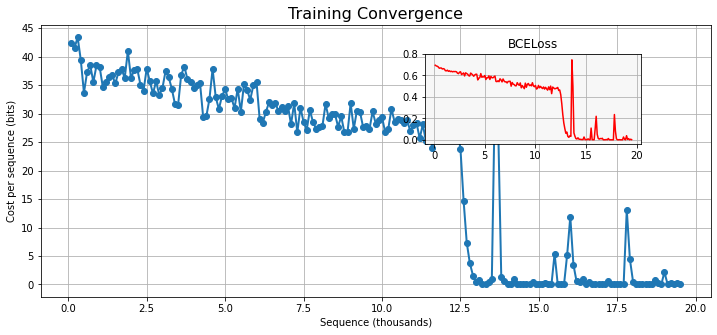

In [73]:
fig = plt.figure(figsize=(12, 5))

# X axis is normalized to thousands
x = np.arange(dv / 1000, (batch_num / 1000) + (dv / 1000), dv / 1000)

# Plot the cost
# plt.plot(x, training_mean[0], 'o-', linewidth=2, label='Cost')
plt.errorbar(x, training_mean[0], yerr=training_std[0], fmt='o-', elinewidth=2, linewidth=2, label='Cost')
plt.grid()
plt.yticks(np.arange(0, training_mean[0][0]+5, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Sequence (thousands)')
plt.title('Training Convergence', fontsize=16)

ax = plt.axes([.57, .55, .25, .25], facecolor=(0.97, 0.97, 0.97))
plt.title("BCELoss")
plt.plot(x, training_mean[1], 'r-', label='BCE Loss')
plt.yticks(np.arange(0, training_mean[1][0]+0.2, 0.2))
plt.grid()

plt.show()

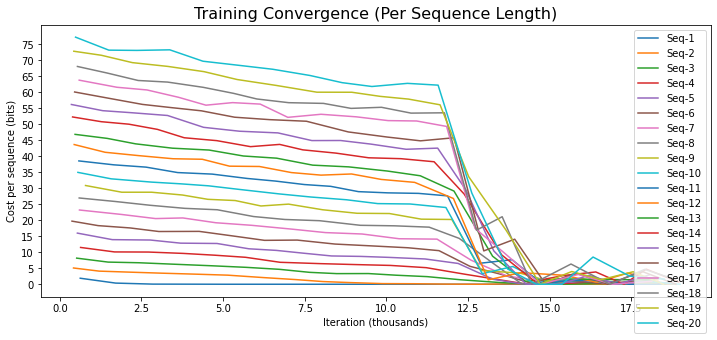

In [74]:
id = 0

loss = history[id]['loss']
cost = history[id]['cost']
seq_lengths = history[id]['seq_lengths']

unique_sls = set(seq_lengths)
all_metric = list(zip(range(1, batch_num+1), seq_lengths, loss, cost))

fig = plt.figure(figsize=(12, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Iteration (thousands)')
plt.title('Training Convergence (Per Sequence Length)', fontsize=16)

for sl in unique_sls:
    sl_metrics = [i for i in all_metric if i[1] == sl]

    x = [i[0] for i in sl_metrics]
    y = [i[3] for i in sl_metrics]
    
    num_pts = len(x) // 50
    total_pts = num_pts * 50
    
    x_mean = [i.mean()/1000 for i in np.split(np.array(x)[:total_pts], num_pts)]
    y_mean = [i.mean() for i in np.split(np.array(y)[:total_pts], num_pts)]
    
    plt.plot(x_mean, y_mean, label='Seq-{}'.format(sl))

plt.yticks(np.arange(0, 80, 5))
plt.legend(loc=0)
plt.show()

## Evalute

In [75]:
import torch
from IPython.display import Image as IPythonImage
from PIL import Image, ImageDraw, ImageFont
import io

In [76]:
# Initialize the Model
model.net.load_state_dict(torch.load("./res2/copy-task-{}-batch-{}.model".format(SEED, batch_num)))

<All keys matched successfully>

In [77]:
seq_len = 60
_, x, y = next(iter(copy_dataloader(1, 1, 8, seq_len, seq_len)))
result = evaluate(model.net, model.criterion, x, y)
y_out = result['y_out']

In [78]:
def cmap(value):
    pixval = value * 255
    low = 64
    high = 240
    factor = (255 - low - (255-high)) / 255
    return int(low + pixval * factor)

def draw_sequence(y, u=12):
    seq_len = y.size(0)
    seq_width = y.size(2)
    inset = u // 8
    pad = u // 2
    width = seq_len * u + 2 * pad
    height = seq_width * u + 2 * pad
    im = Image.new('L', (width, height))
    draw = ImageDraw.ImageDraw(im)
    draw.rectangle([0, 0, width, height], fill=250)
    for i in range(seq_len):
        for j in range(seq_width):
            val = 1 - y[i, 0, j].item()
            draw.rectangle([pad + i*u + inset,
                            pad + j*u + inset,
                            pad + (i+1)*u - inset,
                            pad + (j+1)*u - inset], fill=cmap(val))

    return im

def im_to_png_bytes(im):
    png = io.BytesIO()
    im.save(png, 'PNG')
    return bytes(png.getbuffer())

def im_vconcat(im1, im2, pad=8):
    assert im1.size == im2.size
    w, h = im1.size

    width = w
    height = h * 2 + pad

    im = Image.new('L', (width, height), color=255)
    im.paste(im1, (0, 0))
    im.paste(im2, (0, h+pad))
    return im

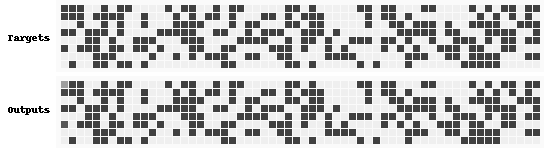

In [79]:
def make_eval_plot(y, y_out, u=12):
    im_y = draw_sequence(y, u)
    im_y_out = draw_sequence(y_out, u)
    im = im_vconcat(im_y, im_y_out, u//2)
    
    w, h = im.size
    pad_w = u * 7
    im2 = Image.new('L', (w+pad_w, h), color=255)
    im2.paste(im, (pad_w, 0))
    
    # Add text
    # font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
    draw = ImageDraw.ImageDraw(im2)
    draw.text((u,4*u), "Targets")#, font=font)
    draw.text((u,13*u), "Outputs")#, font=font)
    
    return im2

im = make_eval_plot(y, y_out, u=8)
IPythonImage(im_to_png_bytes(im))

In [80]:
seq_len = 80
_, x, y = next(iter(copy_dataloader(1, 1, 8, seq_len, seq_len)))

frames = []
# font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
for batch_num in range(500, 20000, 500):
    model = CopyTaskModelTraining()
    model.net.load_state_dict(torch.load("./res2/copy-task-{}-batch-{}.model".format(SEED, batch_num)))
    result = evaluate(model.net, model.criterion, x, y)
    y_out = result['y_out']
    frame = make_eval_plot(y, y_out, u=10)
    
    w, h = frame.size
    frame_seq = Image.new('L', (w, h+40), color=255)
    frame_seq.paste(frame, (0, 40))
    
    draw = ImageDraw.ImageDraw(frame_seq)
    draw.text((10, 10), "Sequence Num: {} (Cost: {})".format(batch_num, result['cost']))
    
    frames += [frame_seq]

In [81]:
im = frames[0]
im.save("./copy-train-801.gif", save_all=True, append_images=frames[1:], loop=0, duration=1000)

im = frames[0]
im.save("./copy-train-80-fast1.gif", save_all=True, append_images=frames[1:], loop=0, duration=100)